<a href="https://colab.research.google.com/github/saibaddala/DL_Assignment_1/blob/main/DL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import wandb

# End any open wandb sessions
wandb.finish()

In [2]:
def acquire_fashion_mnist_data():
    """
    Fetch Fashion MNIST, returning (train_imgs, train_lbls) and (test_imgs, test_lbls),
    plus a sample set containing one image for each label.
    """
    (train_imgs, train_lbls), (test_imgs, test_lbls) = fashion_mnist.load_data()

    unique_tracker = np.unique(train_lbls)
    sample_collection = []

    # Pick one sample image per class
    for im, lab in zip(train_imgs, train_lbls):
        if lab in unique_tracker:
            sample_collection.append(im)
            location = np.where(unique_tracker == lab)
            unique_tracker = np.delete(unique_tracker, location)
        if len(unique_tracker) == 0:
            break

    return (train_imgs, train_lbls), (test_imgs, test_lbls), sample_collection

In [3]:
def flatten(tr_images, tr_labels, ts_images, ts_labels, ratio=0.9):
    """
    Flatten 28x28 images into 1D, normalize pixel values, and split training
    into train and validation sets according to ratio.
    """
    total_train_count = len(tr_images)
    valid_start_index = int(total_train_count * ratio)

    all_flat_train = []
    for i in range(total_train_count):
        flat_image = tr_images[i].reshape(-1) / 255.0
        all_flat_train.append(flat_image)

    all_flat_test = []
    for j in range(len(ts_images)):
        flattened_test = ts_images[j].flatten() / 255.0
        all_flat_test.append(flattened_test)

    xtrain = np.array(all_flat_train[:valid_start_index])
    ytrain = tr_labels[:valid_start_index]
    xval   = np.array(all_flat_train[valid_start_index:])
    yval   = tr_labels[valid_start_index:]
    xtest  = np.array(all_flat_test)
    ytest  = ts_labels

    return xtrain, ytrain, xval, yval, xtest, ytest

In [4]:
def show_class_samples(sample_pics, label_names):
    """
    Plot sample images (one per class) and log the figure to W&B.
    """
    fig = plt.figure(figsize=(8, 8))
    ax_count = 2 * 5  # 2 rows, 5 cols

    for idx in range(ax_count):
        subp = fig.add_subplot(2, 5, idx + 1)
        subp.imshow(sample_pics[idx], cmap='binary')
        subp.set_title(label_names[idx])
        subp.axis('off')

    plt.tight_layout()
    plt.savefig('class_examples.png')

    wandb.login()
    wandb.init(project='DL assignment 1')
    wandb.log({"sample_images": wandb.Image('class_examples.png')})

    plt.show()
    wandb.finish()

In [10]:
class NeuralNetwork:
    """
    A multi-layer neural network with flexible initialization, activations,
    optimizers, and loss functions.
    """
    def __init__(self, input_size, num_outputs, cfg):
        self.in_features   = input_size
        self.out_features  = num_outputs
        self.hidden_count  = cfg["hidden_layers"]
        self.hidden_dim    = cfg["hl_size"]
        self.total_layers  = self.hidden_count + 1

        self.init_approach  = cfg["initialization"]
        self.activ_method   = cfg["activation"]
        self.loss_mech      = cfg["loss"]
        self.optimizer_kind = cfg["optimizer"]
        self.lr             = cfg["learning_rate"]
        self.weight_decay   = cfg["weight_decay"]
        self.batch_size     = cfg["batch_size"]
        self.epochs         = cfg["epochs"]

        self.momentum_factor = cfg.get("momentum_beta", 0.9)
        self.rms_factor      = cfg.get("rms_beta", 0.5)
        self.adam_beta1      = cfg.get("beta1", 0.9)
        self.adam_beta2      = cfg.get("beta2", 0.9)
        self.epsilon_adam    = cfg.get("eps", 1e-8)

        self.W_matrices = []
        self.B_vectors  = []

        self._prepare_parameters()

    def _prepare_parameters(self):
        for i in range(self.total_layers):
            if i == 0:
                in_dim = self.in_features
                out_dim = self.hidden_dim
            elif i == self.total_layers - 1:
                in_dim = self.hidden_dim
                out_dim = self.out_features
            else:
                in_dim = self.hidden_dim
                out_dim = self.hidden_dim

            if self.init_approach == "random":
                W_temp = np.random.randn(out_dim, in_dim) * 0.01
                B_temp = np.random.randn(out_dim, 1) * 0.01
            else:  # Xavier
                scale_factor = np.sqrt(2.0 / (in_dim + out_dim))
                W_temp = np.random.randn(out_dim, in_dim) * scale_factor
                B_temp = np.zeros((out_dim, 1))

            self.W_matrices.append(W_temp)
            self.B_vectors.append(B_temp)

    def feed_forward_neural_net(self, single_input):
        """
        Forward pass for one sample:
        returns (layer_outputs, pre_activation_values).
        """
        layer_outputs   = [None] * self.total_layers
        pre_activations = [None] * self.total_layers
        current_act     = single_input.reshape(-1, 1)

        for idx in range(self.total_layers):
            z_val = np.dot(self.W_matrices[idx], current_act) + self.B_vectors[idx]
            pre_activations[idx] = z_val

            if idx == self.total_layers - 1:
                out_val = self._softmax(z_val)
            else:
                out_val = self._apply_activation(self.activ_method, z_val)

            layer_outputs[idx] = out_val
            current_act = out_val

        return layer_outputs, pre_activations

    def backward_eval(self, layer_outputs, pre_acts, true_label, x_vec):
        """
        Backprop for one sample. Returns gradients for each layer's weights and biases.
        """
        grad_weights = [np.zeros_like(wi) for wi in self.W_matrices]
        grad_biases  = [np.zeros_like(bi) for bi in self.B_vectors]

        # One-hot target
        y_one_hot = np.zeros((self.out_features, 1))
        y_one_hot[true_label] = 1

        # Final layer derivative depends on loss
        if self.loss_mech == "cross_entropy":
            dz_final = (layer_outputs[-1] - y_one_hot)
        else:  # MSE
            diff = layer_outputs[-1] - y_one_hot
            dz_final = diff * (layer_outputs[-1] * (1 - layer_outputs[-1]))

        dz_vals = [None] * self.total_layers
        dz_vals[self.total_layers - 1] = dz_final

        for i in range(self.total_layers - 1, -1, -1):
            if i == 0:
                input_vec = x_vec.reshape(1, -1)
            else:
                input_vec = layer_outputs[i - 1].T

            grad_weights[i] = np.dot(dz_vals[i], input_vec)
            grad_biases[i]  = dz_vals[i]

            if i > 0:
                up_val = np.dot(self.W_matrices[i].T, dz_vals[i])
                dz_vals[i - 1] = up_val * self._activate_derivative(self.activ_method, pre_acts[i - 1])

        return grad_weights, grad_biases

    def training(self, x_train, y_train, x_val, y_val):
        """
        Trains using whichever optimizer is set in the config.
        """
        opt = self.optimizer_kind
        if opt == "sgd":
            self.sgd_optimizer(x_train, y_train, x_val, y_val)
        elif opt == "momentum":
            self.momentum_optimizer(x_train, y_train, x_val, y_val)
        elif opt == "nestrov":
            self.nesterov_optimizer(x_train, y_train, x_val, y_val)
        elif opt == "rmsprop":
            self.rmsprop_optimizer(x_train, y_train, x_val, y_val)
        elif opt == "adam":
            self.adam_optimizer(x_train, y_train, x_val, y_val)
        elif opt == "nadam":
            self.nadam_optimizer(x_train, y_train, x_val, y_val)

    def sgd_optimizer(self, xT, yT, xV, yV):
        """
        Simple SGD with optional L2 regularization.
        """
        total_data = len(xT)
        for ep_idx in range(self.epochs):
            for start in range(0, total_data, self.batch_size):
                end = start + self.batch_size
                x_batch = xT[start:end]
                y_batch = yT[start:end]

                dw_acc = [np.zeros_like(w) for w in self.W_matrices]
                db_acc = [np.zeros_like(b) for b in self.B_vectors]

                for i_sample in range(len(x_batch)):
                    outs, pres = self.forward_eval(x_batch[i_sample])
                    d_w, d_b = self.backward_eval(outs, pres, y_batch[i_sample], x_batch[i_sample])
                    for l_idx in range(self.total_layers):
                        dw_acc[l_idx] += d_w[l_idx]
                        db_acc[l_idx] += d_b[l_idx]

                for l_idx in range(self.total_layers):
                    self.W_matrices[l_idx] -= self.lr * dw_acc[l_idx] + self.weight_decay * self.W_matrices[l_idx]
                    self.B_vectors[l_idx]  -= self.lr * db_acc[l_idx]

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def momentum_optimizer(self, xT, yT, xV, yV):
        """
        Momentum-based GD.
        """
        vel_w = [np.zeros_like(w) for w in self.W_matrices]
        vel_b = [np.zeros_like(b) for b in self.B_vectors]
        total_len = len(xT)

        for ep_idx in range(self.epochs):
            for b_start in range(0, total_len, self.batch_size):
                b_end = b_start + self.batch_size
                x_batch = xT[b_start:b_end]
                y_batch = yT[b_start:b_end]

                gradW = [np.zeros_like(w) for w in self.W_matrices]
                gradB = [np.zeros_like(b) for b in self.B_vectors]

                for idx in range(len(x_batch)):
                    outs, pres = self.forward_eval(x_batch[idx])
                    temp_w, temp_b = self.backward_eval(outs, pres, y_batch[idx], x_batch[idx])
                    for l_idx in range(self.total_layers):
                        gradW[l_idx] += temp_w[l_idx]
                        gradB[l_idx] += temp_b[l_idx]

                for l_idx in range(self.total_layers):
                    vel_w[l_idx] = self.momentum_factor * vel_w[l_idx] + self.lr * gradW[l_idx]
                    self.W_matrices[l_idx] -= vel_w[l_idx] + self.weight_decay * self.W_matrices[l_idx]

                    vel_b[l_idx] = self.momentum_factor * vel_b[l_idx] + self.lr * gradB[l_idx]
                    self.B_vectors[l_idx] -= vel_b[l_idx]

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def nesterov_optimizer(self, xT, yT, xV, yV):
        """
        Nesterov Accelerated Gradient.
        """
        v_w = [np.zeros_like(w) for w in self.W_matrices]
        v_b = [np.zeros_like(b) for b in self.B_vectors]
        length_data = len(xT)

        for ep_idx in range(self.epochs):
            for start_idx in range(0, length_data, self.batch_size):
                end_idx = start_idx + self.batch_size
                subX = xT[start_idx:end_idx]
                subY = yT[start_idx:end_idx]

                # Look-ahead
                for ly in range(self.total_layers):
                    self.W_matrices[ly] -= self.momentum_factor * v_w[ly]
                    self.B_vectors[ly]  -= self.momentum_factor * v_b[ly]

                dw_sum = [np.zeros_like(w) for w in self.W_matrices]
                db_sum = [np.zeros_like(b) for b in self.B_vectors]

                for i_samp in range(len(subX)):
                    outs, pres = self.forward_eval(subX[i_samp])
                    dW, dB = self.backward_eval(outs, pres, subY[i_samp], subX[i_samp])
                    for l_idx in range(self.total_layers):
                        dw_sum[l_idx] += dW[l_idx]
                        db_sum[l_idx] += dB[l_idx]

                for l_idx in range(self.total_layers):
                    v_w[l_idx] = self.momentum_factor * v_w[l_idx] + self.lr * dw_sum[l_idx]
                    self.W_matrices[l_idx] -= v_w[l_idx] + self.weight_decay * self.W_matrices[l_idx]

                    v_b[l_idx] = self.momentum_factor * v_b[l_idx] + self.lr * db_sum[l_idx]
                    self.B_vectors[l_idx] -= v_b[l_idx]

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def rmsprop_optimizer(self, xT, yT, xV, yV):
        """
        RMSProp optimization.
        """
        accum_w = [np.zeros_like(w) for w in self.W_matrices]
        accum_b = [np.zeros_like(b) for b in self.B_vectors]
        data_count = len(xT)

        for ep_idx in range(self.epochs):
            for start_idx in range(0, data_count, self.batch_size):
                end_idx = start_idx + self.batch_size
                chunkX = xT[start_idx:end_idx]
                chunkY = yT[start_idx:end_idx]

                grad_wtemp = [np.zeros_like(w) for w in self.W_matrices]
                grad_btemp = [np.zeros_like(b) for b in self.B_vectors]

                for i_ex in range(len(chunkX)):
                    outs, pres = self.forward_eval(chunkX[i_ex])
                    dw, db = self.backward_eval(outs, pres, chunkY[i_ex], chunkX[i_ex])
                    for ly in range(self.total_layers):
                        grad_wtemp[ly] += dw[ly]
                        grad_btemp[ly] += db[ly]

                for ly in range(self.total_layers):
                    accum_w[ly] = self.rms_factor * accum_w[ly] + (1 - self.rms_factor) * (grad_wtemp[ly] ** 2)
                    accum_b[ly] = self.rms_factor * accum_b[ly] + (1 - self.rms_factor) * (grad_btemp[ly] ** 2)

                    self.W_matrices[ly] -= (self.lr * grad_wtemp[ly]) / (np.sqrt(accum_w[ly] + 1e-4)) \
                                           + self.weight_decay * self.W_matrices[ly]
                    self.B_vectors[ly]  -= (self.lr * grad_btemp[ly]) / (np.sqrt(accum_b[ly] + 1e-4))

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def adam_optimizer(self, xT, yT, xV, yV):
        """
        Adam optimization.
        """
        mw = [np.zeros_like(w) for w in self.W_matrices]
        vw = [np.zeros_like(w) for w in self.W_matrices]
        mb = [np.zeros_like(b) for b in self.B_vectors]
        vb = [np.zeros_like(b) for b in self.B_vectors]

        dcount = len(xT)
        for ep_idx in range(self.epochs):
            for start in range(0, dcount, self.batch_size):
                end = start + self.batch_size
                x_part = xT[start:end]
                y_part = yT[start:end]

                stepGW = [np.zeros_like(w) for w in self.W_matrices]
                stepGB = [np.zeros_like(b) for b in self.B_vectors]

                for i_samp in range(len(x_part)):
                    outs, pres = self.forward_eval(x_part[i_samp])
                    dW, dB = self.backward_eval(outs, pres, y_part[i_samp], x_part[i_samp])
                    for ly in range(self.total_layers):
                        stepGW[ly] += dW[ly]
                        stepGB[ly] += dB[ly]

                for ly in range(self.total_layers):
                    mw[ly] = self.adam_beta1 * mw[ly] + (1 - self.adam_beta1) * stepGW[ly]
                    vw[ly] = self.adam_beta2 * vw[ly] + (1 - self.adam_beta2) * (stepGW[ly] ** 2)

                    mb[ly] = self.adam_beta1 * mb[ly] + (1 - self.adam_beta1) * stepGB[ly]
                    vb[ly] = self.adam_beta2 * vb[ly] + (1 - self.adam_beta2) * (stepGB[ly] ** 2)

                    mw_hat = mw[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    vw_hat = vw[ly] / (1 - self.adam_beta2**(ep_idx + 1))
                    mb_hat = mb[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    vb_hat = vb[ly] / (1 - self.adam_beta2**(ep_idx + 1))

                    self.W_matrices[ly] -= (self.lr * mw_hat / (np.sqrt(vw_hat) + self.epsilon_adam)) \
                                           + self.weight_decay * self.W_matrices[ly]
                    self.B_vectors[ly]  -= (self.lr * mb_hat / (np.sqrt(vb_hat) + self.epsilon_adam))

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def nadam_optimizer(self, xT, yT, xV, yV):
        """
        NAdam optimization (Adam + Nesterov momentum).
        """
        mW = [np.zeros_like(w) for w in self.W_matrices]
        vW = [np.zeros_like(w) for w in self.W_matrices]
        mB = [np.zeros_like(b) for b in self.B_vectors]
        vB = [np.zeros_like(b) for b in self.B_vectors]

        length_d = len(xT)
        for ep_idx in range(self.epochs):
            for start_i in range(0, length_d, self.batch_size):
                end_i = start_i + self.batch_size
                subX = xT[start_i:end_i]
                subY = yT[start_i:end_i]

                dw_sum = [np.zeros_like(w) for w in self.W_matrices]
                db_sum = [np.zeros_like(b) for b in self.B_vectors]

                for s_idx in range(len(subX)):
                    outs, pres = self.forward_eval(subX[s_idx])
                    dW, dB = self.backward_eval(outs, pres, subY[s_idx], subX[s_idx])
                    for ly in range(self.total_layers):
                        dw_sum[ly] += dW[ly]
                        db_sum[ly] += dB[ly]

                for ly in range(self.total_layers):
                    mW[ly] = self.adam_beta1 * mW[ly] + (1 - self.adam_beta1) * dw_sum[ly]
                    vW[ly] = self.adam_beta2 * vW[ly] + (1 - self.adam_beta2) * (dw_sum[ly] ** 2)

                    mB[ly] = self.adam_beta1 * mB[ly] + (1 - self.adam_beta1) * db_sum[ly]
                    vB[ly] = self.adam_beta2 * vB[ly] + (1 - self.adam_beta2) * (db_sum[ly] ** 2)

                    mW_hat = mW[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    vW_hat = vW[ly] / (1 - self.adam_beta2**(ep_idx + 1))
                    mB_hat = mB[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    vB_hat = vB[ly] / (1 - self.adam_beta2**(ep_idx + 1))

                    corr_w = self.adam_beta1 * mW_hat + (1 - self.adam_beta1) * dw_sum[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    self.W_matrices[ly] -= (self.lr / (np.sqrt(vW_hat) + self.epsilon_adam)) * corr_w \
                                           + self.weight_decay * self.W_matrices[ly]

                    corr_b = self.adam_beta1 * mB_hat + (1 - self.adam_beta1) * db_sum[ly] / (1 - self.adam_beta1**(ep_idx + 1))
                    self.B_vectors[ly] -= (self.lr / (np.sqrt(vB_hat) + self.epsilon_adam)) * corr_b

            self._track_and_log(ep_idx, xT, yT, xV, yV)

    def _track_and_log(self, e_index, Xtr, Ytr, Xv, Yv):
        """
        Compute/print/log train and validation metrics at certain epochs.
        """
        if ((self.epochs == 10 and e_index % 2 == 1) or self.epochs == 5):
            tr_acc, tr_loss = self._measure_metrics(Xtr, Ytr)
            vl_acc, vl_loss = self._measure_metrics(Xv, Yv)
            print(f"[Epoch {e_index}] TrainAcc={tr_acc:.4f}, TrainLoss={tr_loss:.4f}, "
                  f"ValAcc={vl_acc:.4f}, ValLoss={vl_loss:.4f}")
            wandb.log({
                "train_accuracy": tr_acc,
                "train_loss": tr_loss,
                "val_accuracy": vl_acc,
                "val_loss": vl_loss,
                "epoch": e_index
            })

    def _measure_metrics(self, Xdata, Ydata):
        """
        Calculates accuracy & average loss for the specified loss function.
        """
        correct_sum = 0
        total_loss = 0.0
        small_eps = 1e-10
        data_len = len(Xdata)

        for i_eval in range(data_len):
            layer_o, _ = self.forward_eval(Xdata[i_eval])
            net_out = layer_o[-1]
            best_class = np.argmax(net_out)
            if best_class == Ydata[i_eval]:
                correct_sum += 1

            if self.loss_mech == "cross_entropy":
                prob_c = max(net_out[Ydata[i_eval]][0], small_eps)
                total_loss += -math.log10(prob_c)
            else:
                ideal_vec = np.zeros((self.out_features, 1))
                ideal_vec[Ydata[i_eval]] = 1
                total_loss += np.sum((net_out - ideal_vec) ** 2)

        average_acc = correct_sum / data_len
        average_loss = total_loss / data_len
        return average_acc, average_loss

    def plot_conf_matrix(self, x_test, y_test):
        """
        Build & log a confusion matrix for test data.
        """
        predictions_list = []
        for i_t in range(len(x_test)):
            outs, _ = self.forward_eval(x_test[i_t])
            pred_label = np.argmax(outs[-1])
            predictions_list.append(pred_label)

        cmatrix = np.zeros((self.out_features, self.out_features))
        for idx, real_class in enumerate(y_test):
            predicted_class = predictions_list[idx]
            cmatrix[real_class][predicted_class] += 1

        class_names = [
            'Ankle boot', 'T-shirt/top', 'Dress', 'Pullover',
            'Sneaker', 'Sandal', 'Trouser', 'Shirt', 'Coat', 'Bag'
        ]
        plt.figure(figsize=(10, 8))
        sns.heatmap(cmatrix, annot=True, fmt='.1f', xticklabels=class_names, yticklabels=class_names)
        plt.title("Resulting Confusion Matrix")
        plt.xlabel("Predicted Category")
        plt.ylabel("Actual Category")
        plt.savefig("matrix_confusion.png")
        wandb.log({"ConfusionMatrix": wandb.Image("matrix_confusion.png")})
        plt.show()

    # Activation functions & derivatives
    def _apply_activation(self, kind, arr):
        if kind == "sigmoid":
            return self._sigmoid(arr)
        elif kind == "tanh":
            return self._tanh(arr)
        elif kind == "relu":
            return self._relu(arr)
        else:
            raise ValueError(f"Unsupported activation: {kind}")

    def _activate_derivative(self, kind, arr):
        if kind == "sigmoid":
            return self._sigmoid_deriv(arr)
        elif kind == "tanh":
            return self._tanh_deriv(arr)
        elif kind == "relu":
            return self._relu_deriv(arr)
        else:
            raise ValueError(f"Unsupported activation derivative: {kind}")

    def _sigmoid(self, z):
        clipped_z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-clipped_z))

    def _sigmoid_deriv(self, arr):
        s_val = self._sigmoid(arr)
        return s_val * (1 - s_val)

    def _tanh(self, z):
        clipped_z = np.clip(z, -100, 100)
        return np.tanh(clipped_z)

    def _tanh_deriv(self, arr):
        return 1.0 - (self._tanh(arr) ** 2)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_deriv(self, arr):
        return (arr > 0).astype(arr.dtype)

    def _softmax(self, z):
        shift_z = z - np.max(z)
        exps = np.exp(shift_z)
        return exps / np.sum(exps, axis=0)

In [11]:
# DEFAULT HYPERPARAMETERS & SWEEP CONFIG
custom_defaults = {
    "epochs": 10,
    "hidden_layers": 3,
    "hl_size": 128,
    "weight_decay": 0,
    "learning_rate": 0.0001,
    "optimizer": "nadam",
    "batch_size": 32,
    "initialization": "xavier",
    "activation": "relu",
    "loss": "cross_entropy",
    "wandb_project": "DL assignment 1",
    "wandb_entity": "",
    "momentum_beta": 0.9,
    "rms_beta": 0.5,
    "beta1": 0.9,
    "beta2": 0.9,
    "eps": 1e-8
}

In [12]:
hyper_sweep = {
    'method': 'bayes',
    'name': 'sweep-2',
    'metric': {
        'goal': 'maximize',
        'name': 'train_accuracy',
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hl_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.0001, 0.001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nestrov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'initialization': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'loss': {'values': ['cross_entropy']},
        'momentum_beta': {'values': [0.9]},
        'rms_beta': {'values': [0.5]},
        'beta1': {'values': [0.9]},
        'beta2': {'values': [0.9]},
        'eps': {'values': [1e-8]},
    }
}

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

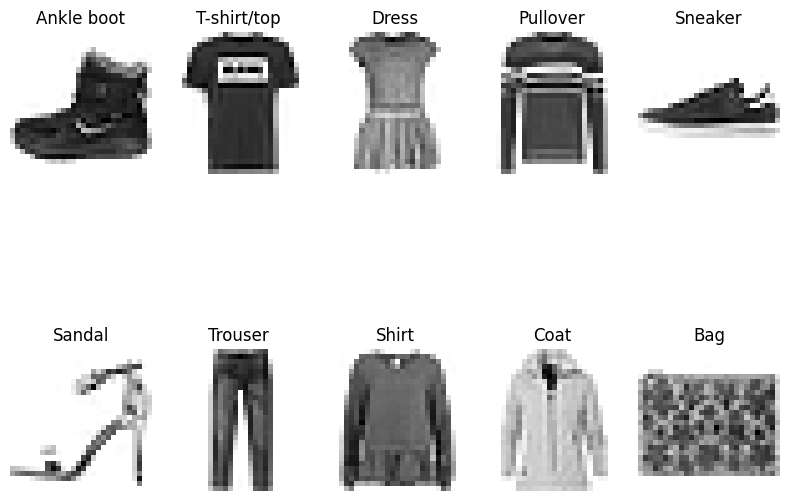

In [13]:
# MAIN ENTRY POINT
if __name__ == "__main__":
    wandb.finish()

    (train_images, train_labels), (test_images, test_labels), sample_set = acquire_fashion_mnist_data()

    label_list = [
        'Ankle boot', 'T-shirt/top', 'Dress', 'Pullover',
        'Sneaker', 'Sandal', 'Trouser', 'Shirt', 'Coat', 'Bag'
    ]
    show_class_samples(sample_set, label_list)

    X_train, Y_train, X_val, Y_val, X_test, Y_test = expand_flatten_normalize(
        train_images, train_labels, test_images, test_labels
    )

    wandb.finish()
    wandb.init(project="DL assignment 1")

    # Set up the sweep
    wandb.finish()
    sweep_key = wandb.sweep(sweep=hyper_sweep, project="DL assignment 1")
    print("Sweep ID:", sweep_key)

    def run_sweep_experiment():
        wandb.finish()
        run_in = wandb.init(project="DL assignment 1")
        config_used = wandb.config
        print("Running with configuration:", config_used)

        netz = FullyConnectedNet(784, 10, config_used)
        netz.training(X_train, Y_train, X_val, Y_val)
        # Possibly do netz.plot_conf_matrix(X_test, Y_test) here

    wandb.agent(sweep_key, function=run_sweep_experiment, count=50)